In [1]:
import sklearn
print(sklearn.__version__)
import torch
print(torch.__version__)
import argparse
print(argparse.__version__)
import numpy
print(numpy.__version__)
import cv2
print(cv2.__version__)
import torchvision
print(torchvision.__version__)
import skimage
print(skimage.__version__)
import scipy
print(scipy.__version__)

0.22.2.post1
1.5.0+cu101
1.1
1.18.5
4.1.2
0.6.0+cu101
0.16.2
1.4.1


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!cp '/gdrive/My Drive/PytorchDigitalPathology/segmentation_epistroma_unet/unet.py' unet.py

In [4]:
import sys
sys.path.append('/content')
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

In [5]:
%cd /gdrive/My\ Drive/PytorchDigitalPathology/segmentation_epistroma_unet/data

/gdrive/My Drive/PytorchDigitalPathology/segmentation_epistroma_unet/data


In [6]:
#v1 
#26/10/2018


dataname="epistroma" #should match the value used to train the network, will be used to load the appropirate model
gpuid=0


patch_size=256 #should match the value used to train the network
batch_size=1 #nicer to have a single batch so that we can iterately view the output, while not consuming too much 
edge_weight=1

In [7]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 7.4MB/s 


In [8]:
# https://github.com/jvanvugt/pytorch-unet
#torch.multiprocessing.set_start_method("fork")
import random, sys
import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage
import skimage
import time

import tables
from skimage import io, morphology
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms


import PIL

In [9]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [10]:
checkpoint = torch.load(f"{dataname}_unet_best_model.pth")

In [11]:
#load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved
model = UNet(n_classes=checkpoint["n_classes"], in_channels=checkpoint["in_channels"], padding=checkpoint["padding"],depth=checkpoint["depth"],
             wf=checkpoint["wf"], up_mode=checkpoint["up_mode"], batch_norm=checkpoint["batch_norm"]).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	122466


<All keys matched successfully>

In [12]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        if(self.img is None): #open in thread
            self.tables=tables.open_file(self.fname)
            self.img=self.tables.root.img
            self.mask=self.tables.root.mask
       
        #get the requested image and mask from the pytable
        img = self.img[index,:,:,:]
        mask = self.mask[index,:,:]
        
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        mask = mask[:,:,None].repeat(3,axis=2) #in order to use the transformations given by torchvision
        weight = weight[:,:,None].repeat(3,axis=2) #inputs need to be 3D, so here we convert from 1d to 3d by repetition
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()
            
            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()

        return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems

In [13]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations

#in the case of using this for output generation, we want to use the original images since they will give a better sense of the exepected 
#output when used on the rest of the dataset, as a result, we disable all unnecessary augmentation.
#the only component that remains here is the randomcrop, to ensure that regardless of the size of the image
#in the database, we extract an appropriately sized patch
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    #transforms.RandomResizedCrop(size=patch_size),
    #transforms.RandomRotation(180),
    #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    #transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    #transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    #transforms.RandomRotation(180),
    ])

phases=["val"]
dataset={}
dataLoader={}
for phase in phases:
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform , mask_transform = mask_transform ,edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) #,pin_memory=True)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


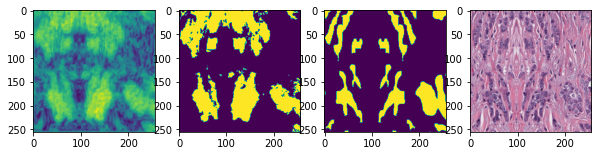

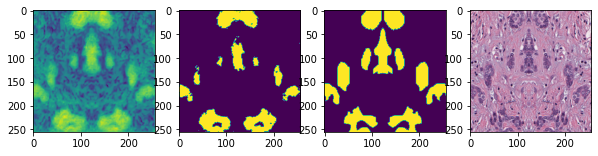

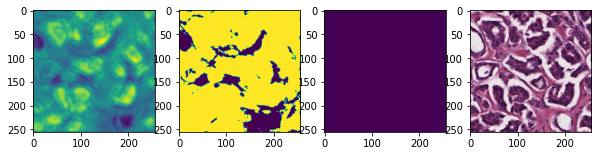

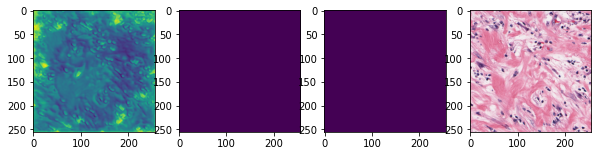

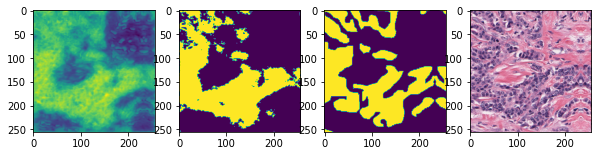

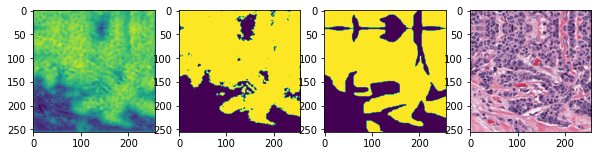

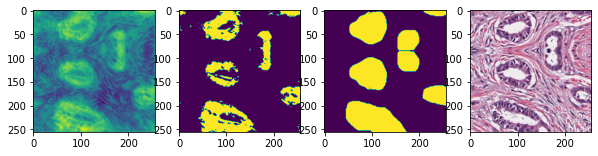

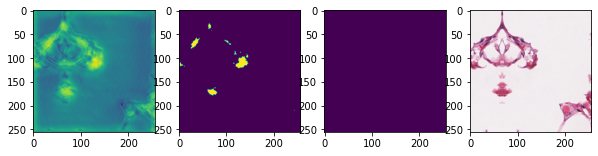

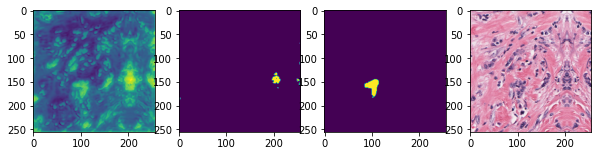

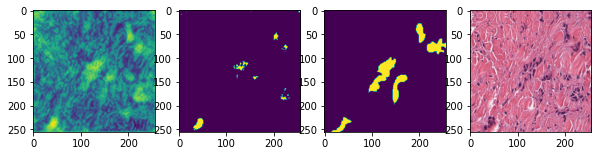

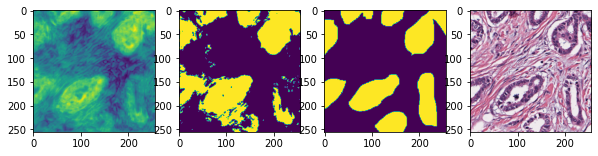

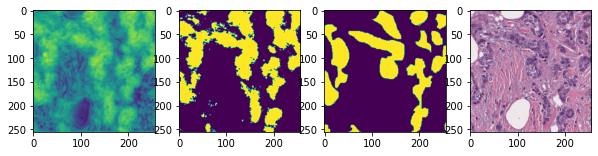

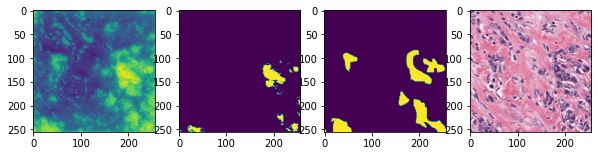

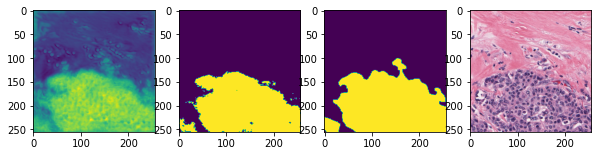

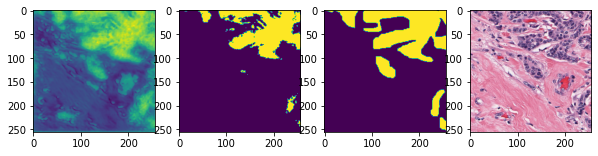

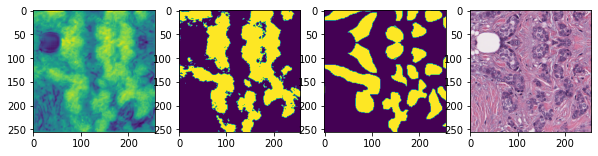

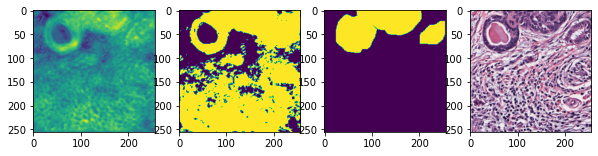

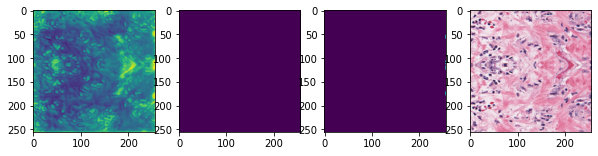

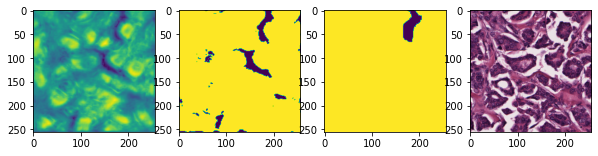

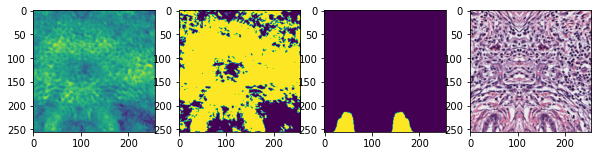

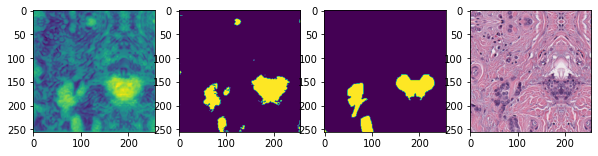

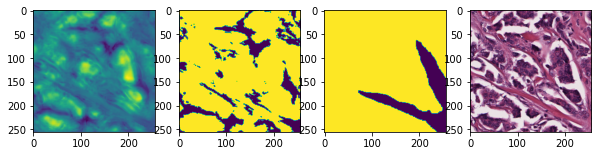

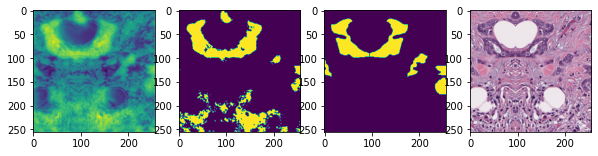

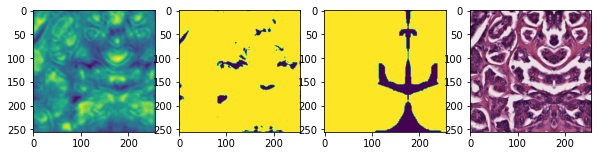

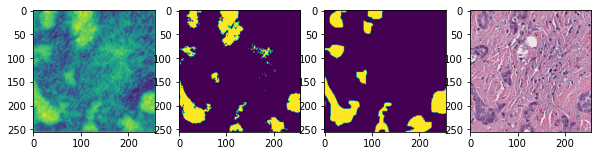

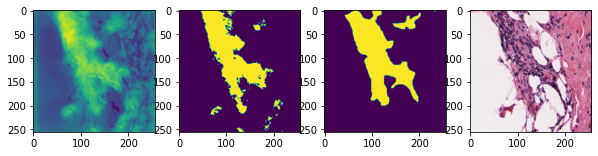

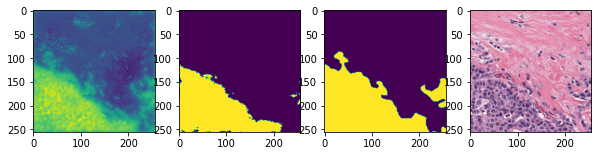

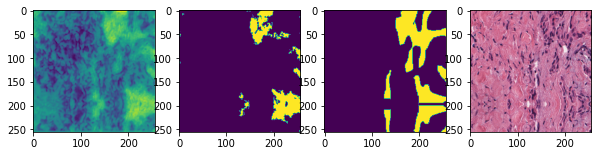

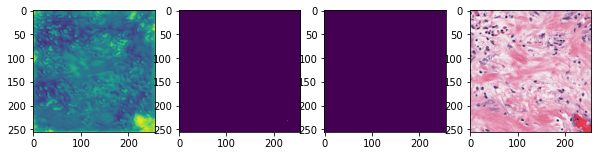

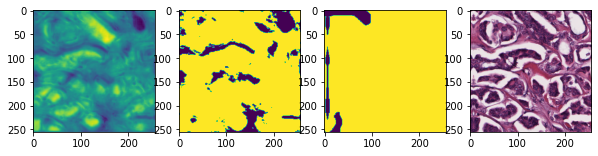

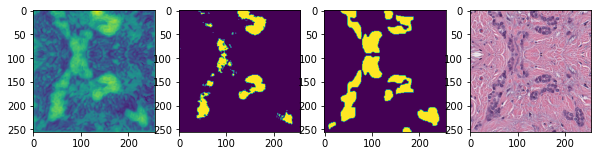

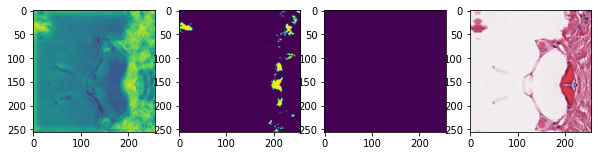

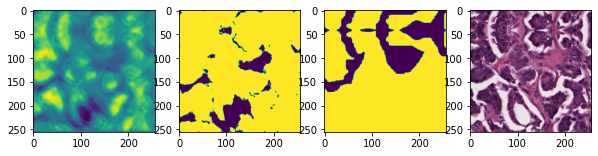

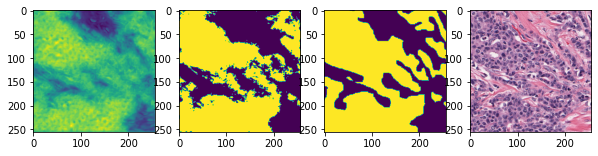

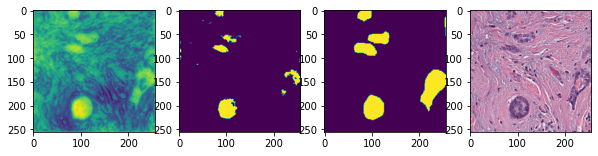

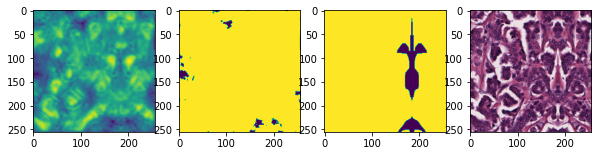

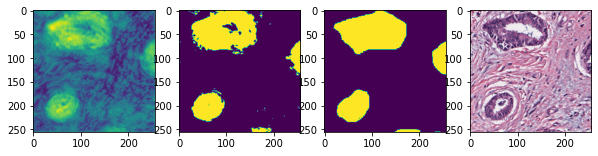

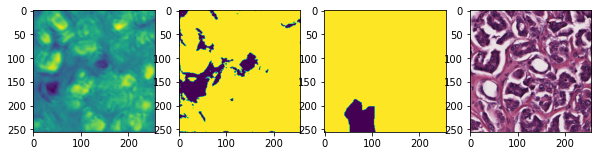

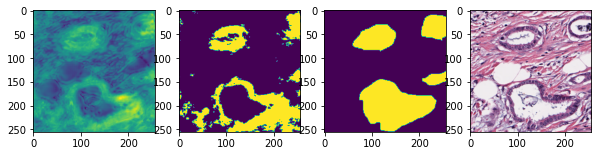

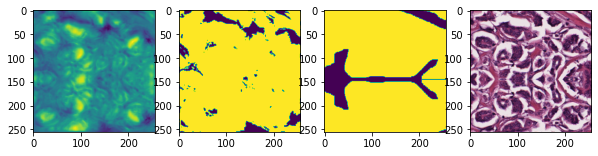

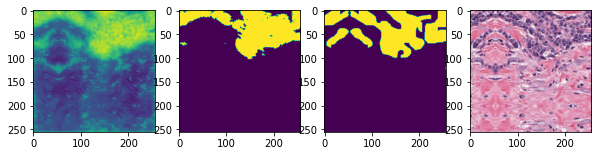

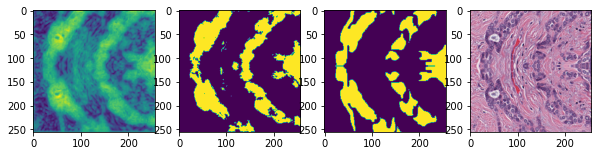

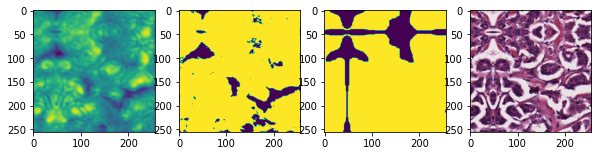

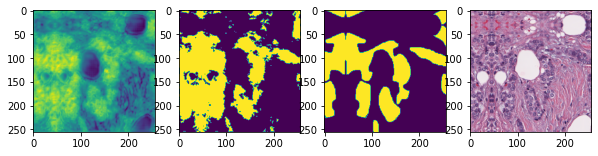

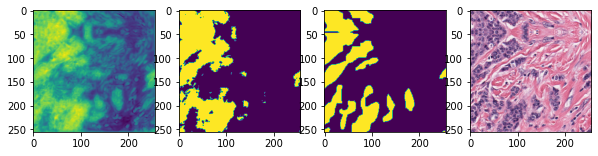

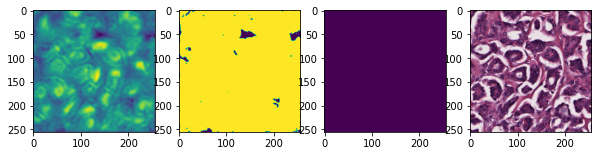

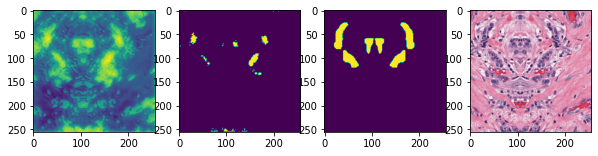

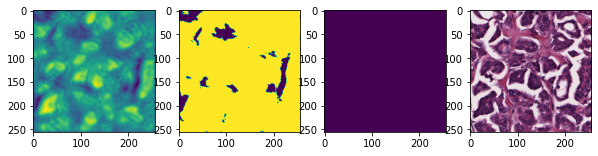

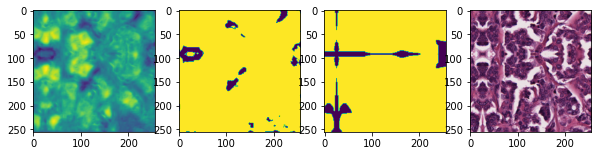

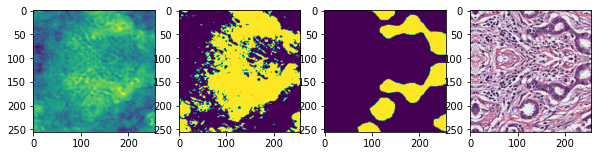

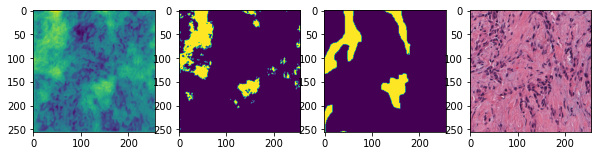

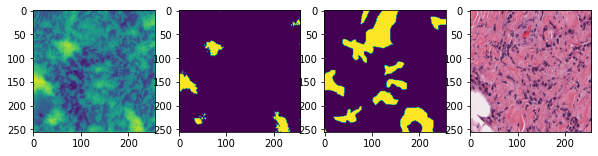

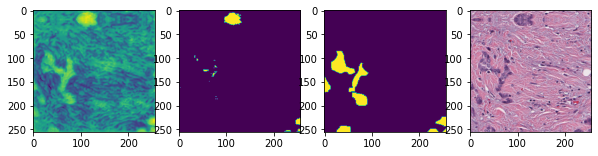

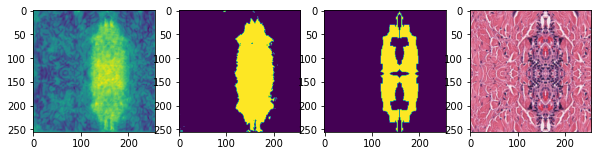

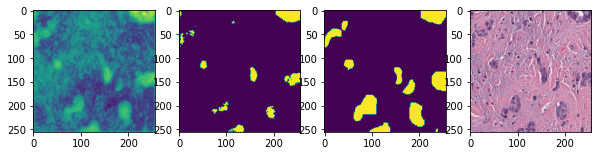

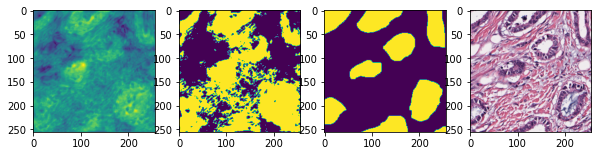

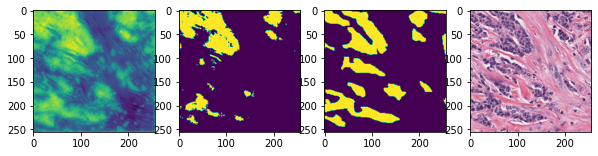

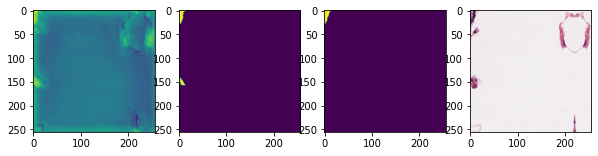

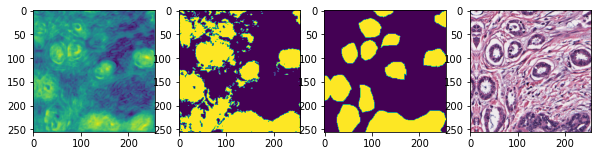

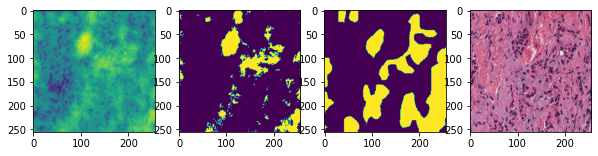

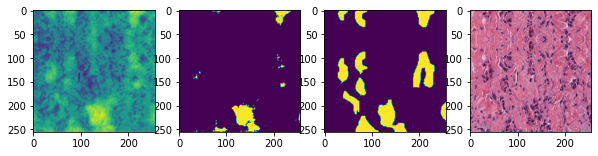

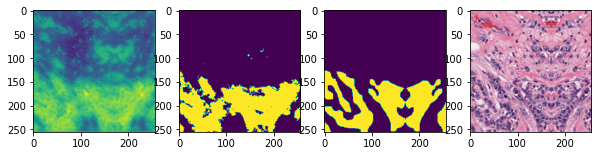

In [ ]:
%matplotlib inline

#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()
for ii , (X, y, y_weight) in enumerate(dataLoader["val"]):
    X = X.to(device)  # [NBATCH, 3, H, W]
    y = y.type('torch.LongTensor').to(device)  # [NBATCH, H, W] with class indices (0, 1)

    output = model(X)  # [NBATCH, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    output=np.moveaxis(output,0,-1)  #reshape moving last dimension
    
    fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

    ax[0].imshow(output[:,:,1])
    ax[1].imshow(np.argmax(output,axis=2))
    ax[2].imshow(y.detach().squeeze().cpu().numpy())
    ax[3].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))